In [1]:
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.recommendation import ALS

# Initiating spark session

In [2]:
spark = SparkSession.builder.appName('Movie_Recommender').getOrCreate()

23/04/02 05:11:13 WARN Utils: Your hostname, Shubhams-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 11.41.226.1 instead (on interface en0)
23/04/02 05:11:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/02 05:11:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Reading movies_rating.csv

In [3]:
movie_df = spark.read.csv('movie_ratings_df.csv', inferSchema = True, header = True)

In [4]:
movie_df.limit(5).toPandas()

,userId,title,rating
0,196,Kolya (1996),3
1,63,Kolya (1996),3
2,226,Kolya (1996),5
3,154,Kolya (1996),3
4,306,Kolya (1996),5


# Dataset Description

In [5]:
movie_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



In [6]:
movie_df.describe().show()

+-------+------------------+--------------------+------------------+
|summary|            userId|               title|            rating|
+-------+------------------+--------------------+------------------+
|  count|            100000|              100000|            100000|
|   mean|         462.48475|                null|           3.52986|
| stddev|266.61442012750865|                null|1.1256735991443156|
|    min|                 1|'Til There Was Yo...|                 1|
|    max|               943|� k�ldum klaka (C...|                 5|
+-------+------------------+--------------------+------------------+



In [7]:
print('Number of different users: {}'.format(movie_df.select('userId').distinct().count()))
print('Number of different movies: {}'.format(movie_df.select('title').distinct().count()))
print('Ratings and count of movies:')
movie_df.groupBy('rating').count().show()

Number of different users: 943
Number of different movies: 1664
Ratings and count of movies:
+------+-----+
|rating|count|
+------+-----+
|     1| 6110|
|     3|27145|
|     5|21201|
|     4|34174|
|     2|11370|
+------+-----+



# Checking the count of distinct fields & sparsity in dataset

In [8]:
all_ratings = movie_df.select('rating').count()

distinct_movies = movie_df.select('title').distinct().count()
distinct_users = movie_df.select('userId').distinct().count()

complete = distinct_movies * distinct_users

sparsity = (1.0 - (all_ratings * 1.0)/complete)*100

print('Movies dataframe is having ','%.2f'%sparsity + '% empty rating field.')

Movies dataframe is having  93.63% empty rating field.


In [9]:
stringIndex = StringIndexer(inputCol = 'title', outputCol= 'title_new')
model = stringIndex.fit(movie_df)
indexed = model.transform(movie_df)
indexed.limit(3).toPandas()

,userId,title,rating,title_new
0,196,Kolya (1996),3,287.0
1,63,Kolya (1996),3,287.0
2,226,Kolya (1996),5,287.0


# Graphical visualization of the dataset

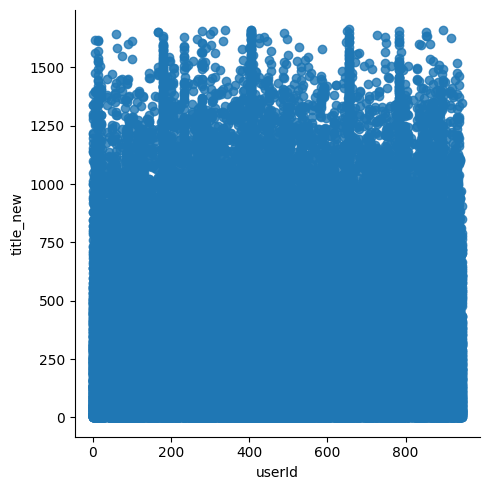

In [10]:
rating_pandas = indexed.toPandas()
sns.lmplot(x='userId', y='title_new', data = rating_pandas, fit_reg=False)

<Axes: xlabel='userId', ylabel='rating'>

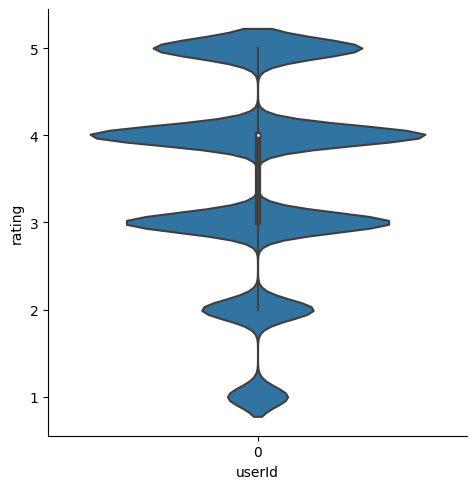

In [11]:

sns.lmplot(x = 'userId', y = 'rating', data = rating_pandas, fit_reg = False)
sns.violinplot([rating_pandas.rating])

<Axes: xlabel='rating', ylabel='count'>

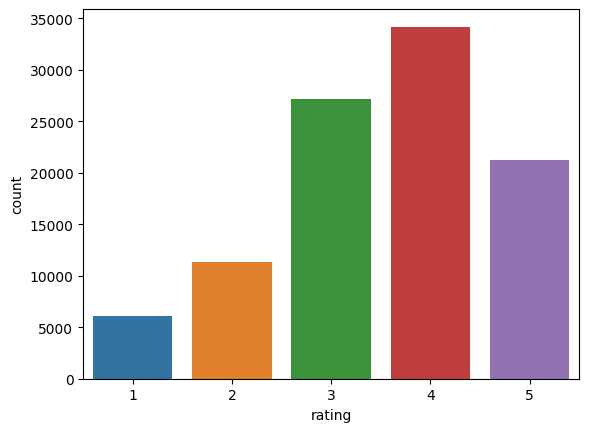

In [12]:
sns.countplot(x = 'rating', data = rating_pandas)

# Implementing ALS model for movie recommendation

The alternating least squares (ALS) algorithm provides collaborative filtering between users and products to find products that the customers might like, based on their previous ratings.

In this case, the ALS algorithm will create a matrix of all users versus all movies. Most cells in the matrix will be empty. An empty cell means the user hasn't reviewed the movie yet. The ALS algorithm will fill in the probable (predicted) ratings, based on similarities between user ratings. The algorithm uses the least squares computation to minimize the estimation errors, and alternates between solving for movie factors and solving for user factors.

In [13]:
train, test = indexed.randomSplit([0.7,0.3])
als_recommender = ALS(maxIter = 10, regParam = 0.01, userCol = 'userId',
                  itemCol = 'title_new',
                  ratingCol='rating',
                  nonnegative=True,
                  coldStartStrategy='drop')

recommender_model = als_recommender.fit(train)

predicted_rating = recommender_model.transform(test)
predicted_rating.limit(5).toPandas()

23/04/02 05:11:37 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/02 05:11:37 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


,userId,title,rating,title_new,prediction
0,148,Amadeus (1984),1,50.0,3.594107
1,148,Around the World in 80 Days (1956),4,540.0,1.936822
2,148,Being There (1979),5,290.0,5.156811
3,148,"Deer Hunter, The (1978)",1,280.0,3.472638
4,148,"Empire Strikes Back, The (1980)",5,18.0,4.104265


In [14]:
evaluator = RegressionEvaluator(metricName = 'rmse', predictionCol = 'prediction', labelCol = 'rating')
rmse = evaluator.evaluate(predicted_rating)
print(f'Root mean square error :{rmse}')

Root mean square error :1.0437906892091013


# Implementing function to retrive movies for particular user

In [15]:
unique_movie = indexed.select('title_new').distinct()

def top_movies(user_id, top_movies):
    
    uniq = unique_movie.alias('uniq')
#     DF for already watched movies
    watched_movies = indexed.filter(indexed['userId'] == user_id).select('title_new')
    wm = watched_movies.alias('wm')
    
    total_movies = uniq.join(wm, uniq.title_new == wm.title_new, how='left')
    
    remaining_movies = total_movies.where(col('wm.title_new').isNull()).select(uniq.title_new).distinct()
    
    remaining_movies = remaining_movies.withColumn("userId", lit(int(user_id)))
    
    recommendation = recommender_model.transform(remaining_movies).orderBy('prediction',
                                                                           ascending = False).limit(top_movies)
    
    movie_title = IndexToString(inputCol='title_new', outputCol='title', labels=model.labels)
    

    final_recommendation = movie_title.transform(recommendation)
    
    return final_recommendation.show(top_movies,False)
    

# Result

In [16]:
print('Movie Recommendation System')
print('-------------------------------------')
user_id = int(input('Enter the user ID  :'))
num_movie =int(input('How many movies to recommend :'))
top_movies(user_id,num_movie)

Movie Recommendation System
-------------------------------------
Enter the user ID  :3
How many movies to recommend :5
+---------+------+----------+-------------------------------------------------------------------+
|title_new|userId|prediction|title                                                              |
+---------+------+----------+-------------------------------------------------------------------+
|577.0    |3     |7.9505167 |Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)           |
|1114.0   |3     |6.5852094 |Bitter Moon (1992)                                                 |
|1140.0   |3     |6.5481625 |White Balloon, The (1995)                                          |
|877.0    |3     |6.5101047 |Cemetery Man (Dellamorte Dellamore) (1994)                         |
|768.0    |3     |6.401641  |Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)|
+---------+------+----------+-------------------------------------------------------------------